In [1]:
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.stats import norm
%matplotlib notebook

In [2]:
window_size = 250
pre_filtering_thresh = 0.25
percent = 0.1

In [3]:
data = np.load("scores.pkl", allow_pickle=True)
df = pd.DataFrame.from_dict(data)
df

,iou_roi_pl,iou_roi_gt,pred_scores,weights,teacher_scores,class_labels,iteration
0,0.892533,0.564606,0.999532,1.000000,0.999776,1,0.0
1,0.842074,0.586626,0.997247,1.000000,0.999027,1,0.0
2,0.815203,0.632871,0.976664,1.000000,0.999443,1,0.0
3,0.756168,0.668692,0.999448,1.000000,0.999722,1,0.0
4,0.707624,0.586877,0.932739,1.000000,0.993906,1,0.0
...,...,...,...,...,...,...,...
954491,0.000000,0.628061,0.279956,0.202585,0.797415,1,7514.0
954492,0.000000,0.000000,0.931930,0.027123,0.972877,2,7514.0
954493,0.000000,0.000000,0.905936,0.091726,0.908274,2,7514.0
954494,0.000000,0.671037,0.957273,0.053933,0.946067,1,7514.0


<IPython.core.display.Javascript object>


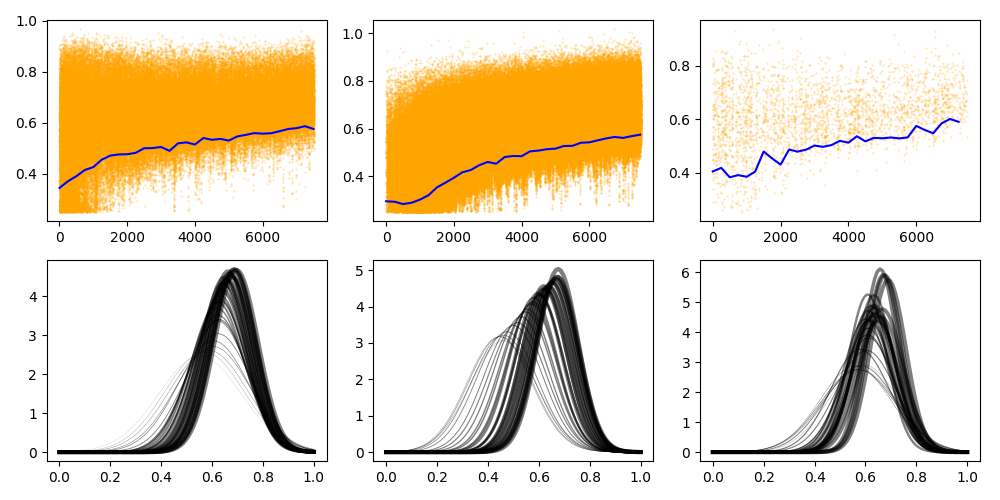

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

In [5]:
classwise_threshs = [[] for _ in range(3)]
for cls in range(3):
    cls_df = df[(df['class_labels'] == cls+1) & (df['iou_roi_pl'] > pre_filtering_thresh)]
    axes[0][cls].scatter(cls_df['iteration'].astype(int), cls_df['iou_roi_pl'], s=0.1, alpha=0.5, c='orange')
    
    # Fit a Gaussian and draw densities
    max_iter = int(cls_df['iteration'].max())
    for step, i in enumerate(range(0, max_iter, window_size)):
        iter_mask = (i <= cls_df['iteration']) & (cls_df['iteration'] < i + window_size)  
        roi_ious_pl = cls_df[iter_mask]['iou_roi_pl']
        mu, sigma = norm.fit(roi_ious_pl)
        lower_bound_iou = norm.ppf(percent, loc=mu, scale=sigma)
        classwise_threshs[cls].append(lower_bound_iou)
        x = np.linspace(0, 1, 100)
        p = norm.pdf(x, mu, sigma)
        width = step * 0.1 + 0.1
        axes[1][cls].plot(x, p, 'k', linewidth=width, alpha=0.5)

/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/farzad/anaconda3/envs/pcdet/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [6]:
fig.tight_layout()

In [7]:
for cls in range(3):
    axes[0][cls].plot(range(0, max_iter, window_size), classwise_threshs[cls], c='blue')